In [38]:
from unstructured.partition.pdf import partition_pdf

output_path = "Data\\"
file_path = output_path + 'ReAct.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="basic",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=1024,       # defaults to 0
    new_after_n_chars=6192,
)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

In [39]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [46]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[2].metadata.orig_elements

In [47]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[2].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '89da329c-6522-4dbd-a620-4e969d394581',
 'text': '£50 62.5 60.0 <575 ats S oso | ates “ 505 — |nenct conse ” — cot-sc 50.0 — ReAct ws Jer 0 5 10 15 20 o 5 qo 15 20 #CoT-SC trials #CoT-SC trials',
 'metadata': {'detection_class_prob': 0.5535728335380554,
  'coordinates': {'points': ((np.float64(829.8877563476562),
     np.float64(259.73388671875)),
    (np.float64(829.8877563476562), np.float64(573.1857299804688)),
    (np.float64(1392.2103271484375), np.float64(573.1857299804688)),
    (np.float64(1392.2103271484375), np.float64(259.73388671875))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-04-09T11:27:41',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 5,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjI

In [48]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [49]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

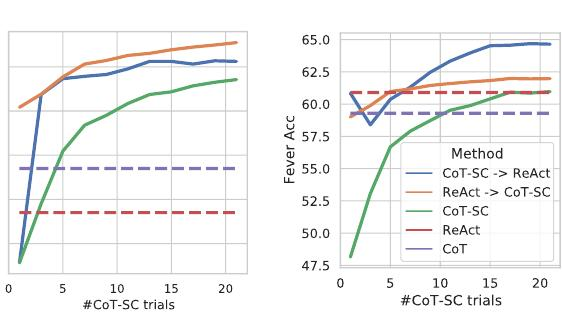

In [50]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [51]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

In [52]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(
    find_dotenv()
)


True

In [53]:
import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [54]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(
    model="gpt-3.5-turbo", 
    temperature=0.2, 
    presence_penalty=0.75, 
    max_tokens=2048,
)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [55]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [57]:
table_summaries

[]

In [58]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [59]:
image_summaries

['The image you\'re describing is composed of two graphs that likely illustrate the performance of different methods in the context of a research study on the transformers architecture.\n\n### Left Graph:\n- **X-axis**: Labeled as "#CoT-SC trials," ranging from 0 to 20.\n- **Y-axis**: Represents a performance metric (not specified but could be accuracy or a similar metric).\n- **Lines**: There are four distinct lines:\n  - **Orange Line**: Appears to show a steady increase, possibly indicating a strong performance as the number of trials increases.\n  - **Blue Line**: Shows a gradual increase but levels off, suggesting it reaches a saturation point.\n  - **Green Line**: Starts lower but exhibits a sharp increase, possibly indicating improved performance with more trials.\n  - **Purple Dashed Line**: Remains constant or exhibits minimal changes, reflecting a baseline or control condition.\n\n### Right Graph:\n- **X-axis**: Also labeled as "#CoT-SC trials," with the same range as the lef

In [62]:
print(image_summaries[2])

The image appears to illustrate a structured approach to answering a question about the number of rooms in a hotel associated with the Cirque du Soleil show "Mystère." The content is presented in a formatted manner, possibly resembling a research paper or technical documentation.

### Key Components of the Image

1. **Question and Labeling**:
   - The main question is asking for the number of rooms in the hotel hosting the Cirque du Soleil show "Mystère."
   - There is a label indicating an outdated response, denoting that the original answer may no longer be accurate.

2. **Answer Sections**:
   - Several sections (1a, 1b, 1c, 1d) break down the reasoning process behind finding the answer:
     - **(1a) Standard**: Gives a straightforward answer of 3,000 rooms, marked as incorrect with an “X.”
     - **(1b) CoT (Chain of Thought)**: This section articulates an iterative reasoning process. It provides the insight that the hotel in question is the Treasure Island, which has 2,884 rooms,

In [63]:
import uuid
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="multi_modal_rag", 
    embedding_function=OpenAIEmbeddings(model="text-embedding-ada-002"), 
    persist_directory="ReAct-VectorDB",
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [64]:
table_ids = [str(uuid.uuid4()) for _ in tables]

In [65]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
if len(table_ids) > 1 :
    summary_tables = [
        Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
    ]
    retriever.vectorstore.add_documents(summary_tables)
    retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
if len(img_ids) > 1 :
    summary_img = [
        Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
    ]
    retriever.vectorstore.add_documents(summary_img)
    retriever.docstore.mset(list(zip(img_ids, images)))

In [66]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [67]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

Wenlong Huang, Fei Xia, Ted Xiao, Harris Chan, Jacky Liang, Pete Florence, Andy Zeng, Jonathan Tompson, Igor Mordatch, Yevgen Chebotar, et al. Inner monologue: Embodied reasoning through planning with language models. arXiv preprint arXiv:2207.05608, 2022b.

Siddharth Karamcheti, Megha Srivastava, Percy Liang, and Dorsa Sadigh. Lila: Language-informed latent actions. In CoRL, pp. 1379–1390, 2021. URL https://proceedings.mlr.press/ v164/karamcheti22a.html.

Takeshi Kojima, Shixiang Shane Gu, Machel Reid, Yutaka Matsuo, and Yusuke Iwasawa. Large language models are zero-shot reasoners. arXiv preprint arXiv:2205.11916, 2022.

Angeliki Lazaridou, Elena Gribovskaya, Wojciech Stokowiec, and Nikolai Grigorev. Internet- augmented language models through few-shot prompting for open-domain question answering. arXiv preprint arXiv:2203.05115, 2022.

Patrick Lewis, Ethan Perez, Aleksandra Piktus, Fabio Petroni, Vladimir Karpukhin, Naman Goyal, Heinrich Küttler, Mike Lewis, Wen-tau Yih, Tim Rocktäs

In [68]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [69]:
response = chain.invoke(
    "What is Chain of thoughts, explain in a detailed manner."
)

print(response)

Chain-of-Thought (CoT) prompting is a methodology utilized in large language models (LLMs) that enhances their capability to tackle complex reasoning tasks by encouraging them to articulate a sequence of thoughts or reasoning steps before arriving at a final answer. This technique was prominently discussed in the context of leveraging LLMs for tasks that require multi-step reasoning, such as question answering and problem-solving.

**Key Characteristics of Chain-of-Thought Prompting:**

1. **Sequential Reasoning:** CoT prompting directs the LLM to generate a "chain" of thoughts, where each thought builds upon or relates to the previous one. This sequential nature mimics human-like reasoning patterns, allowing the model to break down a problem incrementally rather than trying to solve it all at once.

2. **Intermediate Steps:** The model is encouraged to reason out intermediate steps that connect the initial question to the conclusion. This method allows the LLM to handle more intricate

In [70]:
response = chain_with_sources.invoke(
    "What are the LLM Models used in the paper, explain each and every usages"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
    
for image in response['context']['images']:
    display_base64_image(image)

Response: The paper references several LLM (Large Language Model) models, each associated with different tasks and functionalities. Here’s a summary of each model mentioned in the context:

1. **ReAct (Reason + Act)**: This model performs both reasoning and action tasks in an interleaved manner. It generates reasoning traces and task-specific actions, allowing for more effective problem-solving. The model aids in tracking action plans, handling exceptions, and gathering information from external sources. It has shown improved performance on tasks such as question answering and interactive decision-making compared to traditional models.

2. **ALFWorld**: A benchmark that incorporates LLMs for interactive decision-making tasks in a virtual environment. LLMs applied here are capable of understanding and executing commands related to everyday tasks (e.g., putting objects in certain locations). ReAct was tested in ALFWorld, showcasing how it combines reasoning and action to achieve success 

In [71]:
print("Response:", response['response'])

Response: The paper references several LLM (Large Language Model) models, each associated with different tasks and functionalities. Here’s a summary of each model mentioned in the context:

1. **ReAct (Reason + Act)**: This model performs both reasoning and action tasks in an interleaved manner. It generates reasoning traces and task-specific actions, allowing for more effective problem-solving. The model aids in tracking action plans, handling exceptions, and gathering information from external sources. It has shown improved performance on tasks such as question answering and interactive decision-making compared to traditional models.

2. **ALFWorld**: A benchmark that incorporates LLMs for interactive decision-making tasks in a virtual environment. LLMs applied here are capable of understanding and executing commands related to everyday tasks (e.g., putting objects in certain locations). ReAct was tested in ALFWorld, showcasing how it combines reasoning and action to achieve success 